In [1]:
import pandas as pd

def add_metadata_to_obs(
    adata,
    df: pd.DataFrame,
    df_key: str,
    obs_key: str = None,
):
    """
    Merge EVERY column of `df` into `adata.obs` by matching
      df[df_key]  ↔  adata.obs[obs_key] (or adata.obs_names if obs_key is None).

    Keeps duplicates in df_key by dropping all but the first.
    Leaves adata.obs index untouched.
    """

    # 1. Sanity checks
    assert df_key in df.columns, f"{df_key!r} not in metadata DataFrame"
    if obs_key is not None:
        assert obs_key in adata.obs.columns, f"{obs_key!r} not in adata.obs"

    # 2. Deduplicate metadata on the key, keep only first
    df_unique = df.drop_duplicates(subset=[df_key], keep="first").copy()

    # 3. Build a lookup Series indexed by the key
    df_indexed = df_unique.set_index(df_key)

    # 4. Pick the “left” key from adata.obs
    if obs_key is None:
        # map from obs_names
        left_index = pd.Series(adata.obs_names, index=adata.obs_names, name=df_key)
    else:
        # map from an existing obs column
        left_index = adata.obs[obs_key].rename(df_key)

    # 5. For every column in df_indexed (including df_key itself), map into adata.obs
    for col in df_indexed.columns:
        adata.obs[col] = left_index.map(df_indexed[col])

    # 6. Report if anything expected went missing
    missing = adata.obs[df_indexed.columns].isna().any(axis=1).sum()
    if missing:
        print(f"⚠️  {missing} cells did not get full metadata from `{df_key}` join")

    return adata


In [2]:
import scanpy as sc
import pandas as pd

In [3]:
adata=sc.read_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_scvi_runs/processed_adata/adata_nlatent30_nlayers2_nhidden128_nhvg10000.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 1566871 × 10000
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_un

In [10]:
doublets= pd.read_csv('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/combined_scrublet_scores_filtered_bone_atlas.csv')

/tmp/ipykernel_1076223/1043039917.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  doublets= pd.read_csv('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/combined_scrublet_scores_filtered_bone_atlas.csv')


In [11]:
doublets

,Cell_ID,scrublet_score,predicted_doublets,scrublet_cluster_score,bh_pval,predicted_doublets_pval
0,CGCAATGTCAGCAAGA-HCA_BN_F12482363,0.002760,False,0.001950,0.681097,False
1,TAATCACCAATTGACT-HCA_BN_F12482363,0.004377,True,0.001950,0.681097,False
2,CAAGTAACATGACTAT-HCA_BN_F12482363,0.001950,False,0.001950,0.681097,False
3,AAAGCCGCATGTTGCA-HCA_BN_F12482363,0.001463,False,0.001301,0.728714,False
4,TGGCGGTTCTCCTCAA-HCA_BN_F12482363,0.004377,True,0.004377,0.681097,False
...,...,...,...,...,...,...
1579120,ACCCACTCATCGATGT-5478STDY7850149,0.016807,False,0.022009,0.845764,False
1579121,ACTTACTTCCTGTACC-5478STDY7850149,0.011678,False,0.018001,0.845764,False
1579122,CTCTAATCAAGTAATG-5478STDY7850149,0.008368,False,0.010366,0.850723,False
1579123,AGAGCGACACATCCGG-5478STDY7850149,0.017396,False,0.072088,0.434569,False


In [12]:
# 2) Prepare doublets_df: set its index to Cell_ID so the join lines up
doublets_indexed = doublets.set_index('Cell_ID')

# 3) Join all columns from doublets_df into adata.obs, preserving all cells
adata.obs = adata.obs.join(doublets_indexed, how='left')

In [13]:
# List of columns to rename
cols_to_rename = [
    'scrublet_score',
    'predicted_doublets',
    'scrublet_cluster_score',
    'bh_pval',
    'predicted_doublets_pval'
]

# Build the rename mapping
rename_dict = {col: f"{col}_filtered" for col in cols_to_rename}

# Rename in place in adata.obs
adata.obs.rename(columns=rename_dict, inplace=True)


In [14]:
adata

AnnData object with n_obs × n_vars = 1566871 × 10000
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_filtered', 'over_clustering_filtered', 'majority_voting_filtered', 'predicted_labels_Level1_filtered', 'predicted_labels_Level2_filtered', 'majority_voting_Level1_filtered', 'majority_voting_Level2_filtered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predicted_doublet

In [27]:
adata.obs['predicted_doublets_pval_filtered']=adata.obs['predicted_doublets_pval_filtered'].astype(str)
adata.obs['bh_pval_filtered']=adata.obs['bh_pval_filtered'].astype(float)

In [28]:
adata.obs['predicted_doublets_pval_filtered'].value_counts()

predicted_doublets_pval_filtered
False    1534549
True       32239
nan           83
Name: count, dtype: int64

In [20]:
adata.obs['predicted_doublets_pval_unfiltered'].value_counts()

predicted_doublets_pval_unfiltered
False    1547369
True       19502
Name: count, dtype: int64

In [34]:
# Rename columns to use "_unfiltered" suffix
rename_dict = {
    'predicted_labels_filtered':             'predicted_labels_unfiltered',
    'over_clustering_filtered':              'over_clustering_unfiltered',
    'majority_voting_filtered':              'majority_voting_unfiltered',
    'predicted_labels_Level1_filtered':      'predicted_labels_Level1_unfiltered',
    'predicted_labels_Level2_filtered':      'predicted_labels_Level2_unfiltered',
    'majority_voting_Level1_filtered':       'majority_voting_Level1_unfiltered',
    'majority_voting_Level2_filtered':       'majority_voting_Level2_unfiltered',
}

# Apply renaming in-place
adata.obs.rename(columns=rename_dict, inplace=True)

# Optional: display updated columns to verify
print([col for col in adata.obs.columns if col.endswith('_unfiltered')])


['predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_unfiltered', 'predicted_doublets_pval_unfiltered']


In [35]:
adata_celltypist= pd.read_csv('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/all_samples_predictions_filtered_bone_atlas.csv')

In [36]:
add_metadata_to_obs(adata, adata_celltypist,   df_key='Cell_ID')


⚠️  211 cells did not get full metadata from `Cell_ID` join


AnnData object with n_obs × n_vars = 1566871 × 10000
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'pre

In [37]:
annotation_levels= pd.read_csv('/nfs/team298/sm54/BoneAtlasProject/metadata/CellTypist_Hierarchy_Levels3_2_1.csv', index_col=0)

In [38]:
# assume you already have:
#   annotation_levels: a pd.DataFrame with columns ["Level1","Level2","Level3"]
#   adata: your AnnData with obs cols "predicted_labels" and "majority_voting"

# 1) make the two mappings
lvl1_map = annotation_levels.set_index("Level3")["Level1"].to_dict()
lvl2_map = annotation_levels.set_index("Level3")["Level2"].to_dict()

# 2) apply to both columns
for src in ["predicted_labels", "majority_voting"]:
    adata.obs[f"{src}_Level1"] = adata.obs[src].map(lvl1_map)
    adata.obs[f"{src}_Level2"] = adata.obs[src].map(lvl2_map)


In [39]:
(adata.obs['majority_voting_Level1'].value_counts())

majority_voting_Level1
Mesenchymal       802263
Stroma            359530
Haematopoietic    184365
Neural            150229
Erythroid          70150
Gonadal              117
Liver                  6
Name: count, dtype: int64

In [40]:
(adata.obs['majority_voting_Level1_unfiltered'].value_counts())

majority_voting_Level1_unfiltered
Mesenchymal       796217
Stroma            350095
Haematopoietic    180778
Neural            160120
Erythroid          79661
Name: count, dtype: int64

In [43]:
published_anno= pd.read_csv('/nfs/team298/sm54/BoneAtlasProject/metadata/old_annotations/published_annotations_bone_atlas.csv', index_col=0)

/tmp/ipykernel_1076223/4086351752.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  published_anno= pd.read_csv('/nfs/team298/sm54/BoneAtlasProject/metadata/old_annotations/published_annotations_bone_atlas.csv', index_col=0)


In [44]:
published_anno

,Unnamed: 0,Cell_ID,Sanger_ID,published_anno,Organ,published_anno_2,published_anno_level1,published_anno_level2
0,0,AACTCCCCAGTATAAG-FCAImmP7179367,FCAImmP7179367,erythroid macrophage,Femur,MACROPHAGE_IRON_RECYCLING,Erythroid,Erythroid
1,1,AACTGGTGTAAGTGTA-FCAImmP7179367,FCAImmP7179367,neutrophil,Femur,NaN,Haematopoietic,Myeloid
2,2,AAGACCTAGTCATGCT-FCAImmP7179367,FCAImmP7179367,CD14 monocyte,Femur,PROMONOCYTE,Haematopoietic,Myeloid
3,3,AAGGAGCGTGAGTATA-FCAImmP7179367,FCAImmP7179367,DC precursor,Femur,HIGH_MITO,Haematopoietic,Progenitor
4,4,AAGGCAGTCGTGGTCG-FCAImmP7179367,FCAImmP7179367,CD14 monocyte,Femur,CYCLING_DC,Haematopoietic,Myeloid
...,...,...,...,...,...,...,...,...
604277,604960,TTTGTCAAGATAGGAG-WSSS_THYst9384958,WSSS_THYst9384958,DistalMes,limb,NaN,Stroma,Stroma
604278,604961,TTTGTCACATATGCTG-WSSS_THYst9384958,WSSS_THYst9384958,InterZone,limb,NaN,Stroma,Stroma
604279,604962,TTTGTCAGTGATGCCC-WSSS_THYst9384958,WSSS_THYst9384958,InterZone,limb,NaN,Stroma,Stroma
604280,604963,TTTGTCAGTGCACCAC-WSSS_THYst9384958,WSSS_THYst9384958,Mes2,limb,NaN,Stroma,Stroma


In [45]:
add_metadata_to_obs(adata, published_anno,   df_key='Cell_ID')


⚠️  1502066 cells did not get full metadata from `Cell_ID` join


AnnData object with n_obs × n_vars = 1566871 × 10000
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'pre

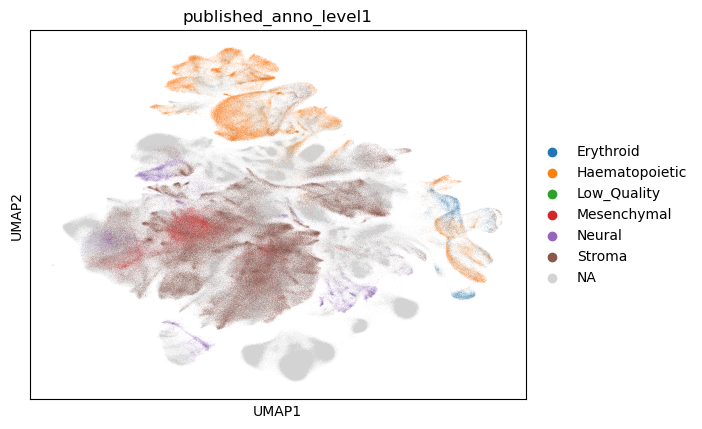

In [46]:
sc.pl.umap(adata, color='published_anno_level1')

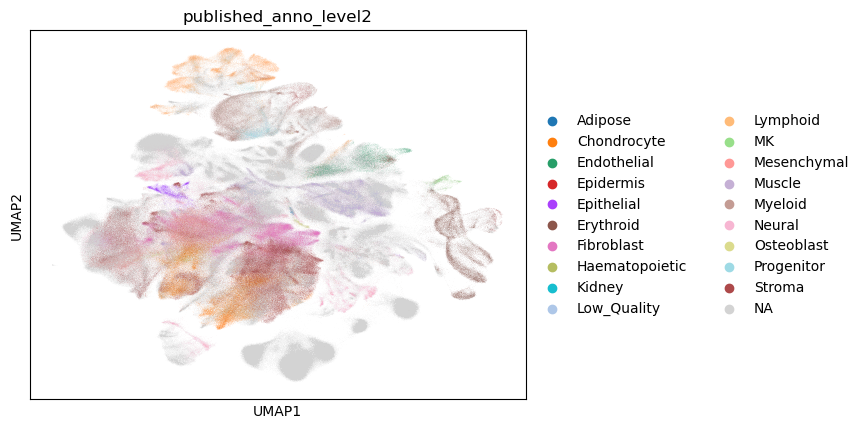

In [47]:
sc.pl.umap(adata, color='published_anno_level2')

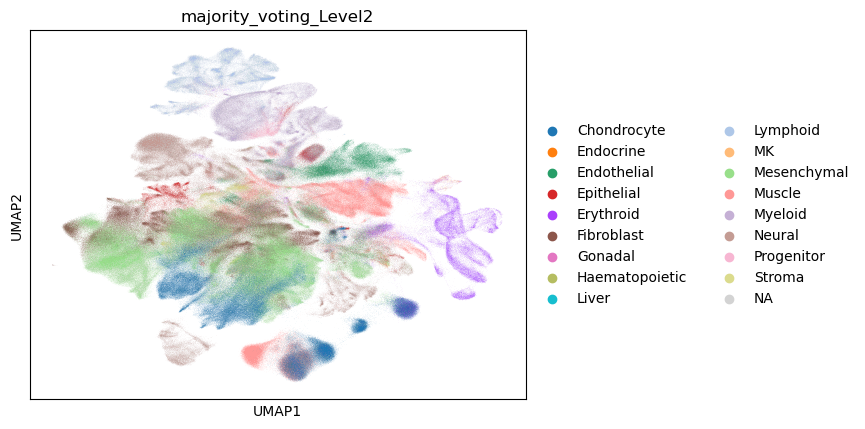

In [48]:
sc.pl.umap(adata, color='majority_voting_Level2')

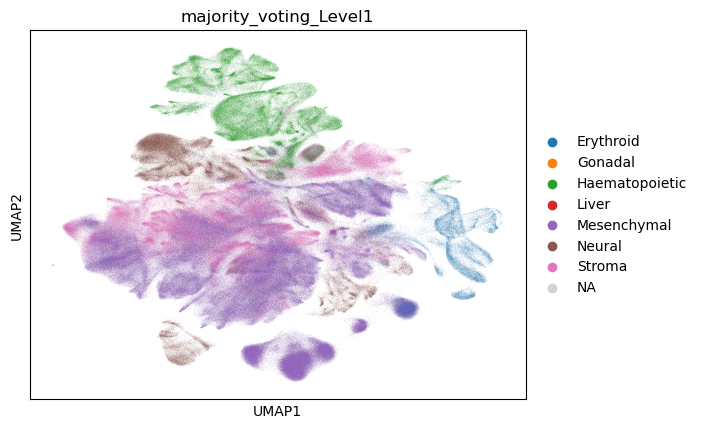

In [49]:
sc.pl.umap(adata, color='majority_voting_Level1')

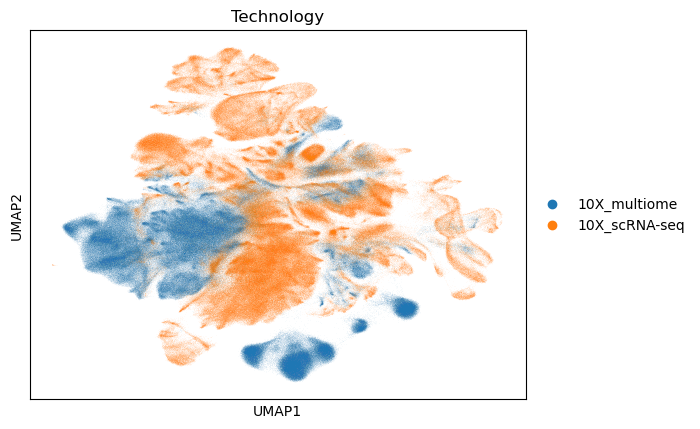

In [51]:
sc.pl.umap(adata, color='Technology')

In [52]:
adata.write_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_scvi_runs/processed_adata/adata_nlatent30_nlayers2_nhidden128_nhvg10000_lognorm.h5ad')

In [50]:
# 1. Normalize counts per cell to 10,000 reads
sc.pp.normalize_total(adata, target_sum=1e4)

# 2. Log1p transform
sc.pp.log1p(adata)


In [ ]:
import scanpy as sc 
adata= sc.read_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_scvi_runs/processed_adata/adata_nlatent30_nlayers2_nhidden128_nhvg10000_lognorm.h5ad')

In [15]:
 adata.obs['majority_voting_Level1']

Cell_ID
CGCAATGTCAGCAAGA-HCA_BN_F12482363      Erythroid
TAATCACCAATTGACT-HCA_BN_F12482363      Erythroid
CAAGTAACATGACTAT-HCA_BN_F12482363      Erythroid
AAAGCCGCATGTTGCA-HCA_BN_F12482363      Erythroid
TGGCGGTTCTCCTCAA-HCA_BN_F12482363    Mesenchymal
                                        ...     
ACCCACTCATCGATGT-5478STDY7850149     Mesenchymal
ACTTACTTCCTGTACC-5478STDY7850149     Mesenchymal
CTCTAATCAAGTAATG-5478STDY7850149     Mesenchymal
AGAGCGACACATCCGG-5478STDY7850149     Mesenchymal
GACCTGGCATACAGCT-5478STDY7850149     Mesenchymal
Name: majority_voting_Level1, Length: 1566871, dtype: category
Categories (7, object): ['Erythroid', 'Gonadal', 'Haematopoietic', 'Liver', 'Mesenchymal', 'Neural', 'Stroma']

In [39]:
import scanpy as sc
import numpy as np

# Assume `adata` is your integrated AnnData object

# 1. Flag PTPRRC positive cells
# ptprrc_exp = adata[:, 'PTPRC'].X
# # Handle sparse vs dense
# if hasattr(ptprrc_exp, "toarray"):
#     ptprrc_exp = ptprrc_exp.toarray().flatten()
# else:
#     ptprrc_exp = ptprrc_exp.flatten()

# adata.obs['PTPRRC_positive'] = ptprrc_exp > 0

# # 2. Compute module scores
# progenitor_genes = ['CD34', 'SPINK2', 'HLF', 'MLLT3']
# lymphoid_genes    = ['CD19', 'MS4A1', 'IL7R']
# myeloid_genes     = ['CD14', 'MRC1', 'CD164']

# sc.tl.score_genes(adata, progenitor_genes, score_name='prog_score')
# sc.tl.score_genes(adata, lymphoid_genes,    score_name='lymph_score')
# sc.tl.score_genes(adata, myeloid_genes,     score_name='myelo_score')

# Define “high” as above 75th percentile; adjust if needed
for score in ['prog_score', 'lymph_score', 'myelo_score']:
    thresh = adata.obs[score].quantile(0.99)
    adata.obs[f'high_{score}'] = adata.obs[score] > thresh

# 3. Existing annotations
adata.obs['published_haem'] = adata.obs['published_anno_level1'].isin(['Haematopoetic', 'Erythroid'])
adata.obs['majvote_haem']   = adata.obs['majority_voting_Level1'].isin(['Haematopoetic', 'Erythroid'])
adata.obs['predicted_haem']   = adata.obs['predicted_labels_Level1'].isin(['Haematopoetic', 'Erythroid'])

# 4. Union filter
mask = (
    adata.obs['PTPRRC_positive'] |
    adata.obs['high_prog_score'] |
    adata.obs['high_lymph_score'] |
    adata.obs['high_myelo_score'] |
    adata.obs['published_haem'] |
    adata.obs['majvote_haem'] | 
    adata.obs['predicted_haem'] 
)

adata_haem = adata[mask].copy()

# 5. Metadata in `adata_haem.obs` now includes:
#    - PTPRRC_positive (bool)
#    - prog_score, lymph_score, myelo_score (floats)
#    - high_prog_score, high_lymph_score, high_myelo_score (bools)
#    - published_haem, majvote_haem (bools)

# Optionally save



In [ ]:
adata=sc.read_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_scvi_runs/processed_adata/adata_nlatent30_nlayers2_nhidden128_nhvg10000.h5ad')

In [33]:
adata.obs['PTPRRC_positive'].value_counts()

PTPRRC_positive
False    1412554
True      154317
Name: count, dtype: int64

In [40]:
adata_haem

AnnData object with n_obs × n_vars = 259912 × 10000
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'pred

In [46]:
adata_haem.obs.to_csv('/nfs/team298/sm54/BoneAtlasProject/data/bone_haem_compartment/haematopoeitic_compartment_celltypist_metadata.csv')

In [47]:
adata_raw= sc.read_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_filtered_with_metadata_scvi.h5ad')

In [48]:
adata_raw

AnnData object with n_obs × n_vars = 1566871 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_un

In [ ]:
common_cells = adata_haem.obs_names.intersection(adata.obs_names)
adata_sub    = adata[common_cells, :].copy()

# 3. Transfer all obs columns from adata_haem into adata_sub.obs
#    (this will exactly replace adata_sub.obs with the haem metadata)
adata_sub.obs = adata_haem.obs.loc[adata_sub.obs_names].copy()


In [49]:
common_cells = adata_haem.obs_names.intersection(adata_raw.obs_names)


In [50]:
common_cells

Index(['CGCAATGTCAGCAAGA-HCA_BN_F12482363',
       'TAATCACCAATTGACT-HCA_BN_F12482363',
       'CAAGTAACATGACTAT-HCA_BN_F12482363',
       'AAAGCCGCATGTTGCA-HCA_BN_F12482363',
       'ACTGAATGTCATGAGC-HCA_BN_F12482363',
       'TGACTTAAGATGCCTG-HCA_BN_F12482363',
       'GGTTTGTAGTTTGAGC-HCA_BN_F12482363',
       'CTAGTTGCACTTACAG-HCA_BN_F12482363',
       'AGCTAGTTCATGGCTG-HCA_BN_F12482363',
       'TAAGCCTAGTTTAACG-HCA_BN_F12482363',
       ...
       'AAAGTAGGTTCCAACA-5478STDY7850149', 'CCGGTAGGTTTGTTTC-5478STDY7850149',
       'CAAGTTGAGACAAAGG-5478STDY7850149', 'CTTGGCTCATCTGGTA-5478STDY7850149',
       'CATCAGATCTTAGCCC-5478STDY7850149', 'ATGTGTGAGATGCCAG-5478STDY7850149',
       'CATCAGAGTGCCTGGT-5478STDY7850149', 'CCGGTAGCAGTTCATG-5478STDY7850149',
       'CGACTTCGTTATTCTC-5478STDY7850149', 'AGGCCACAGGGATGGG-5478STDY7850149'],
      dtype='object', name='Cell_ID', length=259912)

In [51]:
adata_sub    = adata_raw[common_cells, :].copy()


In [53]:
adata_sub.obs = adata_haem.obs.loc[adata_sub.obs_names].copy()


In [57]:
len(adata_sub.obs.columns)

92

In [58]:
len(adata_haem.obs.columns)

92

In [61]:
del adata_sub.uns['log1p']

In [63]:
del adata_sub.uns['hvg']

In [66]:
del adata_sub.obs['Unnamed: 0']

In [68]:
adata_sub.obs['majority_voting_Level2'].value_counts()

majority_voting_Level2
Myeloid           78548
Erythroid         70150
Lymphoid          44969
Mesenchymal       10860
Chondrocyte       10686
Muscle             9893
Endothelial        8518
Fibroblast         8109
Neural             6803
Progenitor         6338
Epithelial         3140
Stroma              851
MK                  542
Haematopoietic      433
Endocrine            18
Gonadal              16
Liver                 2
Name: count, dtype: int64

In [70]:
values_to_rename = ['Endocrine', 'Gonadal', 'Liver']
new_value = 'Stroma'

# Replace the values
adata_sub.obs['majority_voting_Level2'] = adata_sub.obs['majority_voting_Level2'].replace(values_to_rename, new_value)

/tmp/ipykernel_929206/2392908858.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_sub.obs['majority_voting_Level2'] = adata_sub.obs['majority_voting_Level2'].replace(values_to_rename, new_value)


In [79]:
adata_sub.write_h5ad('/nfs/team298/sm54/BoneAtlasProject/data/bone_haem_compartment/haematopoeitic_compartment_celltypist.h5ad')

In [78]:
adata_sub.obs['majority_voting_Level2'].value_counts()

majority_voting_Level2
Myeloid           78548
Erythroid         70150
Lymphoid          44969
Mesenchymal       10860
Chondrocyte       10686
Muscle             9893
Endothelial        8518
Fibroblast         8109
Neural             6803
Progenitor         6338
Epithelial         3140
Stroma              887
MK                  542
Haematopoietic      433
Name: count, dtype: int64

In [ ]:
values_to_rename = ['Endocrine', 'Gonadal', 'Liver']
new_value = 'Stroma'

# Replace the values
adata_sub.obs['majority_voting_Level2'] = adata_sub.obs['majority_voting_Level2'].replace(values_to_rename, new_value)

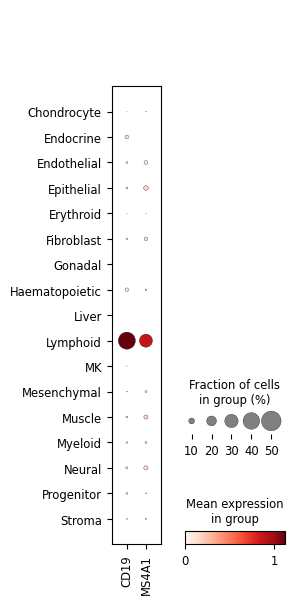

In [77]:
markers = {'Early Progenitor':["CD34",	"SPINK2",	"MLLT3"],
'Myeloid_progenitor':["PRSS57",	"PRTN3",	"AZU1",],
'Neutrophil lineage':["ELANE",	"DEFA4",	"LCN2",	"LTF",	"ORM1",],
'Monocyte_lineage':["CD52",	"S100A8",	"MS4A6A",	"CD14",	"CXCR4","IL1B",	"CD300E",],
'DC_progenitor':["ACY3",],
'pDC':["CLEC4C",	"JCHAIN",	"IRF7",],
'ASDC':["SIGLEC6"],
'DC2':["CLEC10A",	"CD1C",],
'DC1':["CLEC9A",	"BATF3",],
'MIGRATORY_DC':["CCR7",	"LAMP3",],
'LANGERHANS_CELLS':["IDO1","CD207",],
'EO_BASO_MAST':["CLC",	"KIT",	"TPSAB1",],
'MAC_LYVE1_HIGH':["F13A1",	"LYVE1",	"SPP1"],
 'MAC_IRON_RECYCLING':["CD5L",	"APOE",	"VCAM1",],
 'MAC_PROLIFERATING':["TOP2A",	"MKI67",],
 'MAC_MHCII_HIGH':["HLA-DRA",	"HLA-DPA1",	"CLEC7A",],
 'MAC_KUPFFER_LIKE':["ENG",	"KDR",	"CAV1",],
#'MAC_PERI':["SPP1","OLFML3","CCL3"],
#'MAC_ERY':['HBA1','HBA2','HBG2'],
 'MAC_TREM2':["TREM2",	"P2RY12",],
    'MAC_TLF+':["TIMD4", "FOLR2", 'LYVE1'],
'OSTEOCLAST':["MMP9",	"ACP5",]
          }

sc.pl.dotplot(adata_haem, ["CD19","MS4A1"],groupby='majority_voting_Level2')